In [1]:
%load_ext autoreload
%autoreload 2
%env PYTORCH_CUDA_ALLOC_CONF=max_split_size_mb:256

env: PYTORCH_CUDA_ALLOC_CONF=max_split_size_mb:256


In [2]:
import copy
import cProfile
import time

import ase.io
import matplotlib.pyplot as plt
import numpy as np
import sklearn.model_selection
import torch

from utils.combine import CombineRadial, CombineRadialSpecies, CombineSpecies
from utils.dataset import AtomisticDataset, create_dataloader
from utils.linear import LinearModel
from utils.operations import SumStructures, remove_gradient
from utils.soap import PowerSpectrum, CompositionFeatures

torch.set_default_dtype(torch.float64)

In [5]:
n_test = 1000
n_train = 10000

frames = ase.io.read("data/data_shuffle.xyz", f":{n_test + n_train}")

train_frames = frames[:n_train]
test_frames = frames[-n_test:]

train_energies = torch.tensor(
    [frame.info["energy"] for frame in train_frames]
).reshape(-1, 1).to(dtype=torch.get_default_dtype())

test_energies = torch.tensor(
    [frame.info["energy"] for frame in test_frames]
).reshape(-1, 1).to(dtype=torch.get_default_dtype())

train_forces = [
    torch.tensor(frame.arrays["forces"]).to(dtype=torch.get_default_dtype())
    for frame in train_frames
]

test_forces = [
    torch.tensor(frame.arrays["forces"]).to(dtype=torch.get_default_dtype()) 
    for frame in test_frames
]

print(f"using {n_train} training frames")

using 10000 training frames


In [6]:
all_species = set()
for frame in frames:
    all_species.update(frame.numbers)

all_species = list(map(lambda u: int(u), all_species))

# HYPERS_FROM_PAPER = {
#     "interaction_cutoff": 5.0,
#     "max_angular": 9,
#     "max_radial": 12,
#     "gaussian_sigma_constant": 0.3,
#     "gaussian_sigma_type": "Constant",
#     "cutoff_smooth_width": 0.5,
#     "radial_basis": "GTO",
#     "compute_gradients": False,
#     "expansion_by_species_method": "user defined",
#     "global_species": all_species,
# }

HYPERS_SMALL = {
    "cutoff": 4.0,
    "max_angular": 3,
    "max_radial": 6,
    "atomic_gaussian_width": 0.5,
    "cutoff_function": {"ShiftedCosine": {"width": 0.5}},
    "radial_basis": {"SplinedGto": {"accuracy": 1e-6}},
    "gradients": False,
    "center_atom_weight": 1.0,
    # # TODO: implement this in rascaline itself
    # "radial_per_angular": {
    #     # l: n
    #     0: 10,
    #     1: 8,
    #     2: 8,
    #     3: 4,
    #     4: 4,
    # }
}

HYPERS_RADIAL = {
    "cutoff": 5.0,
    "max_angular": 0,
    "max_radial": 10,
    "atomic_gaussian_width": 0.5,
    "cutoff_function": {"ShiftedCosine": {"width": 0.5}},
    "radial_basis": {"SplinedGto": {"accuracy": 1e-6}},
    "gradients": False,
    "center_atom_weight": 1.0,    
}

# Optimization loop, energies only

In [7]:
device = "cpu"

#if torch.cuda.is_available():
#    device = "cuda"

In [8]:
train_dataset = AtomisticDataset(train_frames, all_species, 
                                 {"radial_spectrum": HYPERS_RADIAL, "spherical_expansion":HYPERS_SMALL}, train_energies)
test_dataset = AtomisticDataset(test_frames, all_species, 
                                {"radial_spectrum": HYPERS_RADIAL, "spherical_expansion":HYPERS_SMALL}, test_energies)

do_gradients = False
if do_gradients is True:
    HYPERS_GRAD = copy.deepcopy(HYPERS_SMALL)
    HYPERS_GRAD["gradients"] = do_gradients
    train_dataset_grad = AtomisticDataset(train_frames, all_species, HYPERS_GRAD, train_energies, train_forces, radial_spectrum_n_max=12)
    test_dataset_grad = AtomisticDataset(test_frames, all_species, HYPERS_GRAD, test_energies, test_forces, radial_spectrum_n_max=12)

In [9]:
train_dataloader = create_dataloader(
    train_dataset,
    batch_size=1000,
    shuffle=True,    
    device=device,
)

train_dataloader_no_batch = create_dataloader(
    train_dataset,
    batch_size=len(train_dataset),
    shuffle=False,
    device=device,
)

train_dataloader_single_frame = create_dataloader(
    train_dataset,
    batch_size=1,
    shuffle=False,
    device=device,
)

test_dataloader = create_dataloader(
    test_dataset,
    batch_size=200,
    shuffle=False,
    device=device,
)
if do_gradients is True:
    train_dataloader_grad = create_dataloader(
        train_dataset_grad,
        batch_size=50,
        shuffle=True,
        device=device,
    )

    train_dataloader_grad_no_batch = create_dataloader(
        train_dataset_grad,
        batch_size=len(train_dataset_grad),
        shuffle=False,
        device=device,
    )

    test_dataloader_grad = create_dataloader(
        test_dataset_grad,
        batch_size=50,
        shuffle=False,
        device=device,
    )

In [10]:
def loss_mae(predicted, actual):
    return torch.sum(torch.abs(predicted.flatten() - actual.flatten()))

def loss_mse(predicted, actual):
    return torch.sum((predicted.flatten() - actual.flatten())**2)

In [11]:
class CombinedPowerSpectrum(torch.nn.Module):
    def __init__(self, combiner):
        super().__init__()

        self.combiner = combiner
        self.power_spectrum = PowerSpectrum()

    def forward(self, spherical_expansion):
        combined = self.combiner(spherical_expansion)

        return self.power_spectrum(combined)

        
class MultiBodyOrderModel(torch.nn.Module):
    def __init__(
        self, 
        power_spectrum,
        composition_regularizer,
        radial_spectrum_regularizer,
        power_spectrum_regularizer,        
        optimizable_weights,
        random_initial_weights,
    ):
        super().__init__()

        self.sum_structure = SumStructures()

        # optimizable_weights = False is not very well tested ...
        assert optimizable_weights

        if composition_regularizer is None:
            self.composition_model = None
        else:
            self.composition_model=LinearModel(
            regularizer=composition_regularizer,
            optimizable_weights=optimizable_weights,
            random_initial_weights=random_initial_weights,
        )
        
        if radial_spectrum_regularizer is None:
            self.radial_spectrum_model = None
        else:
            self.radial_spectrum_model = LinearModel(
                regularizer=radial_spectrum_regularizer,
                optimizable_weights=optimizable_weights,
                random_initial_weights=random_initial_weights,
            )

        if power_spectrum_regularizer is None:
            self.power_spectrum_model = None
        else:
            self.power_spectrum = power_spectrum
            self.power_spectrum_model = LinearModel(
                regularizer=power_spectrum_regularizer,
                optimizable_weights=optimizable_weights,
                random_initial_weights=random_initial_weights,
            )

        self.combiner = combiner, 
        self.optimizable_weights = optimizable_weights
        self.random_initial_weights = random_initial_weights

    def forward(self, composition, radial_spectrum, spherical_expansion, forward_forces=False):
        if not forward_forces:
            # remove gradients if we don't need them
            spherical_expansion = remove_gradient(spherical_expansion)
            if radial_spectrum is not None:
                radial_spectrum = remove_gradient(radial_spectrum)                
    
        energies, forces = None, None
        
        if self.composition_model is not None:
            energies_cmp, _ = self.composition_model(composition)
            energies = energies_cmp
            forces = None
    
        if self.radial_spectrum_model is not None:
            radial_spectrum_per_structure = radial_spectrum #self.sum_structure(radial_spectrum)
            energies_rs, forces_rs = self.radial_spectrum_model(radial_spectrum_per_structure, with_forces=forward_forces)
            
            if energies is None:
                energies = energies_rs  
            else:
                energies += energies_rs              
            if forces_rs is not None:
                if forces is None:
                    forces = forces_rs
                else:
                    forces += forces_rs

        if self.power_spectrum_model is not None:
            power_spectrum = self.power_spectrum(spherical_expansion)
            power_spectrum_per_structure = self.sum_structure(power_spectrum)

            energies_ps, forces_ps = self.power_spectrum_model(power_spectrum_per_structure, with_forces=forward_forces)
            if energies is None:
                energies = energies_ps
            else:
                energies += energies_ps
            if forces_ps is not None:
                if forces is None:
                    forces = forces_ps
                else:
                    forces += forces_ps
        
        return energies, forces

    def initialize_model_weights(self, composition, radial_spectrum, spherical_expansion, energies, forces=None, seed=None):
        if forces is None:
            # remove gradients if we don't need them
            spherical_expansion = remove_gradient(spherical_expansion)
            if radial_spectrum is not None:
                radial_spectrum = remove_gradient(radial_spectrum)
            
        if self.composition_model is not None:
            self.composition_model.initialize_model_weights(composition, energies, forces, seed)
        
        if self.radial_spectrum_model is not None:
            radial_spectrum_per_structure = self.sum_structure(radial_spectrum)
            self.radial_spectrum_model.initialize_model_weights(radial_spectrum_per_structure, energies, forces, seed)
        
        if self.power_spectrum_model is not None:        
            power_spectrum = self.power_spectrum(spherical_expansion)
            power_spectrum_per_structure = self.sum_structure(power_spectrum)
            self.power_spectrum_model.initialize_model_weights(power_spectrum_per_structure, energies, forces, seed)

In [12]:
# species combination only
N_PSEUDO_SPECIES = 4
combiner = CombineSpecies(species=all_species, n_pseudo_species=N_PSEUDO_SPECIES)

# # species combination and then radial basis combination
# N_COMBINED_RADIAL = 4
# combiner = torch.nn.Sequential(
#     CombineSpecies(species=all_species, n_pseudo_species=N_PSEUDO_SPECIES),
#     CombineRadial(max_radial=HYPERS_SMALL["max_radial"], n_combined_radial=N_COMBINED_RADIAL),
# )

# # combine both radial and species information at the same time
# combiner = CombineRadialSpecies(
#     n_species=len(all_species), 
#     max_radial=HYPERS_SMALL["max_radial"], 
#     n_combined_basis=N_COMBINED_RADIAL*N_PSEUDO_SPECIES,
# )

composition=CompositionFeatures(all_species, device=device)
power_spectrum = CombinedPowerSpectrum(combiner)

LINALG_REGULARIZER_ENERGIES = 1e-2
LINALG_REGULARIZER_FORCES = 1e-1

model = MultiBodyOrderModel(
    power_spectrum=power_spectrum, 
    composition_regularizer=[1e-10],
    radial_spectrum_regularizer=[LINALG_REGULARIZER_ENERGIES, LINALG_REGULARIZER_FORCES],
    power_spectrum_regularizer=[LINALG_REGULARIZER_ENERGIES, LINALG_REGULARIZER_FORCES],
    optimizable_weights=True, 
    random_initial_weights=True,
)

In [13]:
if model.optimizable_weights:
    TORCH_REGULARIZER_COMPOSITION = 1e-8
    TORCH_REGULARIZER_RADIAL_SPECTRUM = 1e-4
    TORCH_REGULARIZER_POWER_SPECTRUM = 1e-3
else:
    TORCH_REGULARIZER_RADIAL_SPECTRUM = 0.0
    TORCH_REGULARIZER_POWER_SPECTRUM = 0.0

In [14]:
model.to(device=device, dtype=torch.get_default_dtype())

MultiBodyOrderModel(
  (sum_structure): SumStructures()
  (composition_model): LinearModel()
  (radial_spectrum_model): LinearModel()
  (power_spectrum): CombinedPowerSpectrum(
    (combiner): CombineSpecies()
    (power_spectrum): PowerSpectrum()
  )
  (power_spectrum_model): LinearModel()
)

In [15]:
if model.random_initial_weights:
    dataloader_initialization = train_dataloader_single_frame
else:
    dataloader_initialization = train_dataloader_no_batch

In [16]:
# initialize the model
with torch.no_grad():
    for composition, radial_spectrum, spherical_expansions, energies, _ in dataloader_initialization:
        # we want to intially train the model on all frames, to ensure the
        # support points come from the full dataset.
        model.initialize_model_weights(composition, radial_spectrum, spherical_expansions, energies, seed=12345)
        break

del radial_spectrum, spherical_expansions

In [75]:
torch.cuda.memory_stats()['active_bytes.all.current']/1e6

KeyError: 'active_bytes.all.current'

In [38]:
torch.cuda.memory_stats()['allocated_bytes.all.current']/1e6

KeyError: 'allocated_bytes.all.current'

In [39]:
torch.cuda.memory_stats()['reserved_bytes.all.current']/1e6

KeyError: 'reserved_bytes.all.current'

In [18]:
lr = 0.2
# optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=0.0)
optimizer = torch.optim.LBFGS(model.parameters(), lr=lr, line_search_fn="strong_wolfe", history_size=128)

In [17]:
lr = 0.1
# optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=0.0)
optimizer = torch.optim.LBFGS(model.parameters(), lr=lr)#, line_search_fn="strong_wolfe", history_size=128)

all_losses = []
all_tests=[]

filename = f"{model.__class__.__name__}-{N_PSEUDO_SPECIES}-mixed-{n_train}-train"
if model.optimizable_weights:
    filename += "-opt-weights"

if model.random_initial_weights:
    filename += "-random-weights"

output = open(f"{filename}.dat", "w")
output.write("# epoch  train_loss  test_mae\n")
n_epochs_total = 0

In [19]:
sum(p.detach().cpu().numpy().nbytes for p in model.parameters())
train_dataset._collatetime = 0

In [20]:
assert model.optimizable_weights
himem = True
if himem and len(all_losses)==0:
    composition, radial_spectrum, spherical_expansions, energies, _ = next(iter(train_dataloader_no_batch))

for epoch in range(250):
    epoch_start = time.time()

    def single_step():
        global composition, radial_spectrum, spherical_expansions, energies
        optimizer.zero_grad()
        if device=="cuda":
            print(f"mem. before:  {torch.cuda.memory_stats()['allocated_bytes.all.current']/1e6} MB allocated, {torch.cuda.memory_stats()['reserved_bytes.all.current']/1e6} MB reserved ")
        loss = torch.zeros(size=(1,), device=device)
        if himem:
            predicted, _ = model(composition, radial_spectrum, spherical_expansions, forward_forces=False)
            loss += loss_mse(predicted, energies)
        else:
            for composition, radial_spectrum, spherical_expansions, energies, _ in train_dataloader:
                try:
                    predicted, _ = model(composition, radial_spectrum, spherical_expansions, forward_forces=False)
                except:
                    if device=="cuda":
                        print(f"mem. during:  {torch.cuda.memory_stats()['allocated_bytes.all.current']/1e6} MB allocated, {torch.cuda.memory_stats()['reserved_bytes.all.current']/1e6} MB reserved ")
                    raise
                loss += loss_mse(predicted, energies)
        loss /= n_train
        if model.composition_model is not None:
            loss += TORCH_REGULARIZER_COMPOSITION * torch.linalg.norm(model.composition_model.weights)
        if model.radial_spectrum_model is not None:
            loss += TORCH_REGULARIZER_RADIAL_SPECTRUM * torch.linalg.norm(model.radial_spectrum_model.weights)
        if model.power_spectrum_model is not None:
            loss += TORCH_REGULARIZER_POWER_SPECTRUM * torch.linalg.norm(model.power_spectrum_model.weights)

        loss.backward(retain_graph=False)
        print(loss.item(), np.linalg.norm(model.composition_model.weights.grad.numpy()))
        return loss
            
    loss = optimizer.step(single_step)
    loss = loss.item()
    all_losses.append(loss)

    epoch_time = time.time() - epoch_start
    if epoch % 1 == 0:
        print("norms", np.linalg.norm(0 if model.composition_model is None else model.composition_model.weights.detach().cpu().numpy()),
                  np.linalg.norm(0 if model.radial_spectrum_model is None else model.radial_spectrum_model.weights.detach().cpu().numpy()),
                  np.linalg.norm(0 if model.power_spectrum_model is None else model.power_spectrum_model.weights.detach().cpu().numpy())
                 )
        print("gradients", 
                  np.linalg.norm(0 if model.composition_model is None else model.composition_model.weights.grad.detach().cpu().numpy()),
                  np.linalg.norm(0 if model.radial_spectrum_model is None else model.radial_spectrum_model.weights.grad.detach().cpu().numpy()),
                  np.linalg.norm(0 if model.power_spectrum_model is None else model.power_spectrum_model.weights.grad.detach().cpu().numpy())
                 )
        with torch.no_grad():
            predicted = []
            reference = []
            for tcomposition, tradial_spectrum, tspherical_expansions, tenergies, _ in test_dataloader:
                reference.append(tenergies)
                predicted_e, _ = model(tcomposition, tradial_spectrum, tspherical_expansions, forward_forces=False)
                predicted.append(predicted_e)

            reference = torch.vstack(reference)
            predicted = torch.vstack(predicted)
            test_mae = loss_mae(predicted, reference)/n_test

            output.write(f"{n_epochs_total} {loss} {test_mae}\n")
            output.flush()
        all_tests.append(test_mae.item())
        print(f"epoch {n_epochs_total} took {epoch_time:.4}s, optimizer loss={loss:.4}, test mae={test_mae:.4}")
    
    del loss
    n_epochs_total += 1

426124.9856723694 10466.428263161522
421352.56854786153 10419.469529047206
400997.24681594 10214.299612973076
360811.1345686371 9770.902628768723
328000.3286096472 9376.020644526277
300099.9759131623 9012.8930650611
275777.74434368475 8671.374927603829
253391.4426191513 8331.945268218135
230878.4323264811 7960.683639754946
205400.42343358707 7493.656422717106
174182.61938425136 6816.415994914378
144292.44461825935 5936.285677639763
125639.97053016625 5227.521135296979
105615.42884063619 4355.5552338982725
91596.52152874946 3671.2997466564398
80752.03926054374 3128.018874338242
68717.37443537012 2504.0486800575864
58893.679668214434 1989.719464870589
49637.44414552271 1587.4608400146008
39353.778019418554 1241.6980533897156
29196.216024818623 986.4136077537904
20787.404583509553 783.0672738332369
norms 1.459934582072727 45.00363043105861 28.36796565718368
gradients 783.0672738332369 1019.5087925581904 13852.917246791842
epoch 0 took 525.6s, optimizer loss=4.261e+05, test mae=104.9
20787

138.76778511633108 5.595861653218456
137.6388391996674 5.02206230823314
136.33821071156555 5.476029272635356
134.76917856769575 4.586647809535454
133.40091974222034 4.4939361283405965
132.02773310603473 4.3257449559636605
130.4055711551555 4.619252854356618
norms 6.728034299412007 42.46703306413216 29.933464299507385
gradients 4.619252854356618 14.515121478169917 56.00704817940101
epoch 8 took 479.6s, optimizer loss=166.3, test mae=8.789
130.4055711551555 4.619252854356618
128.9589915941088 4.200702203277205
127.44348638413015 4.5729894033862655
125.98965168904043 4.572747851903665
124.68004953845714 4.2754438453570085
123.19971714702542 5.5226243925807355
121.76820124103506 3.81510569995339
120.27369148490982 6.438526403281603
119.23448008190624 5.544783784233943
118.36423531436157 5.892553870727492
117.38135135906339 5.690828699644514
116.17281054768043 5.7443231301009625
114.77879188779063 5.80964883986482
113.63075280928085 5.459216434967857
112.52044526323297 6.009902796988683
111

38.62862330697124 2.496697878934802
38.326764206507065 2.458327074332493
37.94094506027382 2.208036665208764
37.56054685053332 2.2860706048790473
37.19953045205286 2.171609314644394
36.84243396925882 2.321428553753455
36.515530260236815 2.273795525441806
36.20148972123929 2.409916579260264
35.910137921481194 2.399907601269486
35.621183755104056 2.6952164373186487
35.417500417376964 2.6161988242727015
35.25022298330503 2.5897755119378805
35.03755182773075 2.5951499168047243
34.854150862138596 2.4000734423839636
34.662161426237866 2.7204341974339505
34.50390480875271 2.4252939256504367
34.345414362298676 2.4757412897706543
norms 15.12056566319255 40.73819540245832 32.3395651469473
gradients 2.4757412897706543 6.475879545984747 23.200045343821035
epoch 17 took 481.1s, optimizer loss=39.57, test mae=4.875
34.345414362298676 2.4757412897706543
34.161049509395426 2.0179713845340195
33.96383299513482 2.2355503806450576
33.77715984641125 1.8308983552791687
33.60545511394772 1.9479028619000363


14.20624078504301 1.1445129185769451
14.14554175448504 1.0302194312966015
14.088455646708722 0.9420684193078954
14.031481142355002 0.9378242307669904
13.971489566751522 0.8193406697060013
norms 21.310582314510548 39.617541167270176 34.708549918380136
gradients 0.8193406697060013 3.5266582229461014 5.846697104653848
epoch 25 took 481.2s, optimizer loss=15.41, test mae=3.356
13.971489566751522 0.8193406697060013
13.9262416052955 0.7631914298791266
13.872286852117222 0.7997711095574483
13.813776572810001 0.7644285522408585
13.75166100590412 0.7701907006968675
13.673908146794348 0.8142177987256759
13.606363458825427 0.7608761031591887
13.5379071538431 0.8498537018941197
13.475514269664647 0.7979689139648994
13.413207785352578 0.8569854902479291
13.352619787623826 0.7984015513002642
13.293901301449958 0.8186091076442245
13.224781343662324 0.9300519749811981
13.16841919116394 0.8815348760884977
13.106724355316956 0.9768286296292679
13.037375950097104 0.9259993366826466
12.960665137467508 0.9

7.494756989132048 0.7662218754396204
7.46774700693194 0.7700857352561122
7.434136423561651 0.7001458183592669
7.403895077142678 0.6802655016477138
7.376515473347448 0.6287655618642418
7.34991224430034 0.6706330387770862
7.325989561963037 0.5641084239495293
7.305940966152407 0.5728453386904458
7.285540992444962 0.5072169730549262
7.267556254252095 0.47488327250622214
7.247223980954781 0.5046479179873644
7.220966831076411 0.4712647274613927
7.196821866634213 0.48098359748801117
7.170066003919632 0.5177973357117067
7.142305407399527 0.5230807610007625
7.112465969227646 0.5899650494241022
7.0840767014240535 0.5864679736864029
7.058298181553267 0.5570926024414996
7.0288922596356 0.8828723831854272
norms 22.928692768565725 38.67126194343681 35.48997780770586
gradients 0.8828723831854272 2.1803234845908537 23.09061742681919
epoch 34 took 483.4s, optimizer loss=7.546, test mae=2.295
7.0288922596356 0.8828723831854272
7.008802072490316 0.8367475135948107
6.985998948533246 0.7126896977717484
6.9

5.016770380768949 0.5065833834339937
5.01004677822665 0.5149037037331604
5.002257444051662 0.532808128707055
4.992729439317348 0.5439293134951503
4.983675676757684 0.5523742758566202
4.974400277305902 0.5663490461717279
norms 23.652488548929597 38.226967898555344 35.87321431776054
gradients 0.5663490461717279 1.6115722692461538 3.026260310061431
epoch 42 took 483.0s, optimizer loss=5.153, test mae=1.965
4.974400277305902 0.5663490461717279
4.961752522117778 0.6762568599655917
4.950727441434729 0.6736464135047577
4.937516645787298 0.6632966687386502
4.922029657320385 0.6274490787717695
4.908357046524167 0.6260289695875201
4.892575783662576 0.5681972203832222
4.880767778784179 0.5327357485751577
4.8691639406850715 0.5157191613642532
4.8554380393817445 0.5236477878061044
4.845134362470128 0.4927537835068309
4.835918890986374 0.5047379982468557
4.825995219755122 0.4871364123255694
4.815830992222351 0.49329316925252925
4.806448336534555 0.4812498025630103
4.796863975297421 0.521815299545903

3.893017491131161 0.28521351489336355
3.8889034118285926 0.28053345284197506
3.885069764136094 0.2732632682987365
3.881487856665155 0.2799166074795175
3.8777942634364653 0.2590799099121306
3.8737512585865748 0.27915734224916544
3.8699092635185353 0.26307233573204436
3.8661056715220985 0.2803442236162248
3.8620013670107634 0.2775900117423964
3.8580092575039653 0.28814657136343286
3.853564055556647 0.306447667656884
3.8494663409169774 0.3055052094710466
3.8450596693110213 0.3337322633790063
3.8401885083776435 0.31669645545356806
3.8355883911092876 0.3316333853256272
3.831248182642403 0.3242038604788061
3.827115402621885 0.2959695122617209
3.8228738368227164 0.3024991754126496
3.819740824036354 0.28184698913145106
3.8164534353868205 0.29086651820076903
3.8133316677321782 0.27935152268595465
norms 24.494326219645924 37.8856315040917 36.31232390785696
gradients 0.27935152268595465 1.0360792071910983 1.62180884834735
epoch 51 took 482.2s, optimizer loss=3.893, test mae=1.776
3.81333166773217

3.301034628932583 0.2974649472512173
3.298038595191253 0.31959325729363675
3.2947430754716676 0.3086744739031992
3.291478300518285 0.3233794062139988
3.2883041803245447 0.2922840646333836
3.2854647614368897 0.2918291440390617
3.2824588635895546 0.2558918795411774
3.279976720922734 0.243815821218006
3.27729521412883 0.22683985002359214
3.2743650395406756 0.20909871088243065
3.2716412625728406 0.20905415388414877
3.269201546243861 0.19265311097126345
3.2669184371345663 0.22886795414396344
norms 25.177203066188763 37.68410569909363 36.678003259091284
gradients 0.22886795414396344 0.9246366523143726 1.8470918136336332
epoch 59 took 490.6s, optimizer loss=3.327, test mae=1.68
3.2669184371345663 0.22886795414396344
3.264832073447862 0.2154342635967741
3.263211580305279 0.21396161528507857
3.261346810352668 0.21826568962402657
3.259267234144055 0.19942529803292355
3.257270526181569 0.2478739597072439
3.2557956759889404 0.23997068255346723
3.253939043067701 0.23120433506052285
3.25144470550344

2.8931048430142248 0.1922174567208476
2.8916068482154795 0.1859154028428729
2.889590331996328 0.17822559721735395
2.88729186562552 0.16775189332980936
2.884997900705088 0.15329409194826674
norms 25.58266149163657 37.542749179182834 36.89051227893414
gradients 0.15329409194826674 0.7194228635813524 1.0733419400304431
epoch 67 took 483.9s, optimizer loss=2.919, test mae=1.582
2.884997900705088 0.15329409194826674
2.8828739989956973 0.13703725297087627
2.8808693216136882 0.13268276238222865
2.8789570315644504 0.11252470658444251
2.877164596066519 0.1082475470651955
2.8755374360724897 0.09837500433287086
2.8736877229002573 0.10479145082095749
2.871774325036507 0.10340058131483097
2.8695856089136753 0.11225964796515175
2.8667791284120536 0.12691453925027005
2.8639909499450433 0.12461279207570157
2.86147811962106 0.1550603339760781
2.859121774459706 0.1538535167420518
2.85691061304132 0.1594136378415861
2.854385249189587 0.18708657344073787
2.8521993331569573 0.17743504541914995
2.8499202268

epoch 75 took 480.4s, optimizer loss=2.632, test mae=1.504
2.591758151444071 0.1881463887436066
2.589480296244584 0.18234245899408177
2.5875158119955937 0.16486066669328925
2.585836803937396 0.15815292726274865
2.584424345022028 0.15463016194349896
2.5832963576802124 0.14719101077723337
2.5822280124268375 0.14970829231345206
2.5812200950633373 0.14788266419161591
2.5802253696572133 0.14336160804343487
2.579440361538121 0.14220808690505424
2.5785200023251114 0.13850720057342336
2.5774940228348693 0.13304290639989821
2.5764301613238336 0.13610354349968048
2.5752727877942534 0.1263607300279026
2.5741752897626156 0.13057847939293968
2.5730545217771366 0.12139414847527863
2.5719489179037147 0.12380891846409837
2.57085271533773 0.12184838598974011
2.569612129105089 0.12687386014340482
2.568576526144689 0.12360388427447996
2.567493234049231 0.1283052405177475
norms 26.012410216423735 37.43287880979582 37.12674462903542
gradients 0.1283052405177475 0.6743188516789657 0.41407769417628354
epoch 

2.3820660151621595 0.11767323875675477
2.3814108588567553 0.11264451372693127
2.380652869507844 0.11281539188882213
2.3795977515267905 0.12258550049358163
2.3785425414733177 0.11535059628659523
2.377470856122356 0.11408024526670217
2.376240863450831 0.11666797076786417
2.3750925508906575 0.10628172945905091
2.3740289281915423 0.10957872402622978
2.3728555371561715 0.11334969206131858
2.3719787185539825 0.11398926761168914
2.370914227251 0.1325954713021348
2.369720898849251 0.12423107723922996
2.368615656245657 0.14656801207127118
2.367500697389081 0.129186755303991
norms 26.24118252893748 37.37486166943486 37.238959596204246
gradients 0.129186755303991 0.47880206766109085 1.5623491908177323
epoch 84 took 483.3s, optimizer loss=2.387, test mae=1.426
2.367500697389081 0.129186755303991
2.3665979959346504 0.1382212616768219
2.3656902192737403 0.12680761097198995
2.3648373439191843 0.13409713918694843
2.3640180455966746 0.1276093890730262
2.36337341931359 0.12880470316936077
2.362707868731

2.215243714072745 0.13296040548415888
2.2140785624195303 0.1308367179416977
2.2128617535687187 0.12980880685632495
2.2113578342001468 0.13130232280637033
2.209405203975395 0.13880643226774578
2.2077826098397733 0.14551673263381767
2.2062283558206013 0.14280334867546074
2.2047759048467612 0.14564072005069376
norms 26.48042348363259 37.32306961022704 37.36327525637849
gradients 0.14564072005069376 0.5235316727092955 0.5341845229341435
epoch 92 took 477.8s, optimizer loss=2.231, test mae=1.388
2.2047759048467612 0.14564072005069376
2.203466453368253 0.14269979385195708
2.202107495140859 0.14298786967431726
2.20088950716906 0.1372197331521122
2.199855662598079 0.1769919297492101
2.199048968778963 0.1598277094218728
2.1982977025953283 0.14435466405918118
2.1975414942474414 0.1295949895358128
2.1967925337555885 0.1170133128473896
2.196101959844727 0.10822851186438295
2.195506622236475 0.10260769707607886
2.19494104390109 0.10199207438869985
2.1943280714864573 0.10570232792904516
2.1936914930

epoch 100 took 487.4s, optimizer loss=2.069, test mae=1.342
2.05223537004439 0.13243312545344416
2.051512281771075 0.13338871099249075
2.0505138913601844 0.1405275109620903
2.049477025153323 0.12902254978803332
2.04850467825029 0.12670877761096308
2.04743955008104 0.16945999565021133
2.0465416975633652 0.15838285076774944
2.0455233453995594 0.1445389173808285
2.0444222152149467 0.13095023260206515
2.043285769633535 0.1382349720450163
2.042161419782703 0.1261287681346581
2.0413409046085698 0.12226511055741633
2.040557895483917 0.12296727667683623
2.0398111731955133 0.11776494915007495
2.039110752381793 0.12084133096251924
2.03841583525158 0.11654038464001139
2.0377397551361196 0.11960691062883534
2.0370784851836583 0.12286988983094174
2.0364312247421426 0.12026378663117848
2.0358008179362996 0.14346675161416408
2.035311478413704 0.13977499488483452
norms 26.82348764940864 37.28411987162352 37.554207300259556
gradients 0.13977499488483452 0.4808981372246712 0.40760056357922736
epoch 101 

1.934451467310172 0.12311956382724339
1.9336250936710226 0.12069280007213642
1.9329129053847973 0.11729535518845452
1.9319541685987314 0.1129877724363083
1.9308765181207959 0.11014701610827114
1.9309915207557038 0.3268939952410865
1.930417068858284 0.17441794623364612
1.929495884280226 0.16027544616388462
1.9285538942499054 0.14209518486382872
1.9276020176023945 0.13440778777526127
1.9266610871122225 0.12133498732196392
1.9259858218754609 0.11183978969644205
1.925403865921533 0.11236833034340032
1.9247815310331264 0.10582042384520504
1.9243031944281428 0.10581385046021495
1.9238313877854611 0.12045571430753482
1.923389639840087 0.1207536454520985
norms 27.110822054045624 37.27036310983312 37.719439390145766
gradients 0.1207536454520985 0.41797080514334056 0.4944433173188953
epoch 109 took 507.1s, optimizer loss=1.938, test mae=1.27
1.923389639840087 0.1207536454520985
1.9228904087249314 0.13003992976485856
1.9222969801564223 0.12557968717217488
1.921683233372145 0.14578889511478177
1.9

1.8318981519224218 0.13802684250663036
1.8311641487408297 0.12051232012480391
1.8304798370933595 0.10301560436789611
1.829939793894795 0.08488552772852066
1.8294845030746696 0.07270037487549502
1.8289567894952206 0.059925321804821775
1.8285421042323662 0.05082522746518922
1.8280566040933344 0.07672715944854705
1.8276121986637393 0.07731024977435218
1.8270620032343738 0.07490963281128887
1.8263357738744113 0.08106365219297122
norms 27.351555832690924 37.260782914243855 37.846734798443684
gradients 0.08106365219297122 0.39827541526214805 0.3694315930853178
epoch 117 took 485.8s, optimizer loss=1.839, test mae=1.243
1.8263357738744113 0.08106365219297122
1.825506972556887 0.09392557198250555
1.8248444030722617 0.09415402378713116
1.8241815373464927 0.10065308891062844
1.8234319955229448 0.09885605767370173
1.8227821697855522 0.09989785429725159
1.8221850696438464 0.09351545388273577
1.8214635917138082 0.10304158970497793
1.8208162330819806 0.09327031260570892
1.820184288526463 0.147600743

1.7449234990310847 0.13220947090906973
1.7441844380287617 0.1250455273909072
1.7433526808555768 0.13927099051572303
1.7426651600380663 0.12963747397448008
1.7419603560010315 0.11624388020057648
norms 27.616995755188466 37.25994884337105 37.99473459042443
gradients 0.11624388020057648 0.34337252386914136 0.5599708071817051
epoch 125 took 487.9s, optimizer loss=1.75, test mae=1.216
1.7419603560010315 0.11624388020057648
1.7412422292034515 0.1147078332712039
1.7405211347740281 0.09677325017403715
1.740034634690569 0.09281200097257307
1.7396388037472492 0.0903268356595997
1.739254159244234 0.08919353625532418
1.7388614958236959 0.08820844989225733
1.7384970490825205 0.08911138996659279
1.7381289393165187 0.08792365881369628
1.7377779036518302 0.08868905048915791
1.737453570143346 0.09481754790288588
1.7370705463031306 0.09466882477591039
1.736759067340416 0.09611440207449054
1.7364206586456266 0.10074041355815708
1.736024616559863 0.10403348137434526
1.735626365136707 0.10795986443561505
1

epoch 133 took 483.7s, optimizer loss=1.684, test mae=1.204
1.6767320795603866 0.07541847381205925
1.6762819558902815 0.09971324585130945
1.6759603685277815 0.088676734252305
1.675699039354095 0.08186286448416077
1.675411330419548 0.07417933956870376
1.6750953376523852 0.06731361602004313
1.6747833844312572 0.06483607363862959
1.6744802133615189 0.061810937902794544
1.6741872786772514 0.0641184012444459
1.673924501954043 0.06741224247811838
1.6737024120953923 0.06818124677705273
1.6734534599485333 0.07764219764325271
1.6731890583493885 0.07696257979797136
1.6729458244613067 0.08377463647357229
1.6726799798832204 0.0827837267070134
1.6724216851824574 0.08521985886343758
1.6721602669480324 0.08485452763564444
1.6718434532135094 0.08432733123051893
1.6715142316349043 0.08723988125806739
1.6711923761710836 0.08331692994139758
1.670879063342712 0.08880109488022515
norms 27.847424070090018 37.25396363094311 38.10712580055482
gradients 0.08880109488022515 0.2998933525622531 0.3773175822373830

1.6239575380198294 0.07390233992145458
1.6237360174488071 0.07333661885305048
1.6234392087021388 0.08781471652438703
1.623159027630255 0.08725444563329506
1.6228643118608996 0.08936989802032091
1.6225061845667124 0.08738317255921502
1.6222392560530754 0.08531424269535523
1.6219480964182313 0.08179727512879202
1.621652407304615 0.07853547564877886
1.6213391891565907 0.07055272570559046
1.6211037269841229 0.06387911621094079
1.6208703734659737 0.058576521361346875
1.6205577291643654 0.06232845282646262
1.6202536490430708 0.06282975439322393
1.6199189730650059 0.06316730540294035
1.6195173224261175 0.07582214628213411
1.6191072811948013 0.08230603812624075
norms 28.095897136639046 37.24652411185118 38.22987268606879
gradients 0.08230603812624075 0.2893878915103131 0.5362866584975586
epoch 142 took 490.5s, optimizer loss=1.625, test mae=1.198
1.6191072811948013 0.08230603812624075
1.6187169326214292 0.08046384969952178
1.6183605815608466 0.09344194017617724
1.618057751915816 0.099171813099

1.5729938638914753 0.07179884408857615
1.5727917912612759 0.07347396923158889
1.5725489167374778 0.07830199428428856
1.5723078758904576 0.07193027106340595
1.5720958138152272 0.07480855602343023
1.5718525535601091 0.07529993140447135
1.5716474694559914 0.07153090566796748
1.5714115598287248 0.08318167769767379
1.5711563966678672 0.07360667314426896
1.5709311295021449 0.07113163050196875
1.5706610194963413 0.07954211852007166
1.5704618859827673 0.07034354985338347
norms 28.330094914719098 37.24509862719607 38.3531824021704
gradients 0.07034354985338347 0.28189490996628214 0.7249327234380022
epoch 150 took 486.4s, optimizer loss=1.575, test mae=1.178
1.5704618859827673 0.07034354985338347
1.5702461027999541 0.06386442132353247
1.5699880746184067 0.054071456877311
1.5697065594730477 0.05007639966058811
1.5694590937865502 0.048364154657736344
1.5692224846093465 0.0512783417344188
1.568971403779995 0.05516628991694884
1.5687497049783146 0.05907725285899471
1.5685169310332003 0.0643917536556

1.5303918523719517 0.07342505545552416
1.5301581446820811 0.07684209866495299
1.529903330788961 0.07556161693416592
1.529650746357413 0.07760263188007463
1.5294111296304487 0.07407836623495294
1.529195417217129 0.0750290390436404
1.5289924614362476 0.07154619716301024
norms 28.568529927396078 37.2501553021911 38.485593814544394
gradients 0.07154619716301024 0.2768041079869594 0.3320744229421498
epoch 158 took 489.2s, optimizer loss=1.533, test mae=1.17
1.5289924614362476 0.07154619716301024
1.5288217484837516 0.07219389842485087
1.5286783790692402 0.07025294160057885
1.5285146463939314 0.07502404951966808
1.5283928248487704 0.07388593642785195
1.528260467557024 0.07445658372188832
1.5280792937777412 0.07542323947653246
1.5279097166255202 0.0709970980110039
1.5277431589726544 0.07237563787318395
1.5275217423144076 0.06755915244704822
1.5273663675125544 0.06454438899952104
1.5271735598793195 0.06215804504899566
1.526919547830173 0.059508792550196546
1.5265991671188188 0.06344272252986662

1.488151253640777 0.10510990431255347
norms 28.773414327537466 37.245093222151205 38.594267075579545
gradients 0.10510990431255347 0.2697028826497412 0.3753637736017834
epoch 166 took 491.3s, optimizer loss=1.492, test mae=1.175
1.488151253640777 0.10510990431255347
1.4878557544591857 0.10337074410757566
1.487612212798887 0.09732842434128797
1.4873785263790644 0.09604494585799861
1.4871572645321445 0.08996429261934874
1.4869418964486725 0.0871159992957641
1.4867189535011422 0.07982762860872421
1.4864887717128943 0.0758862262832729
1.4862795547630774 0.07268030561727651
1.4860674600141768 0.06689145762428869
1.4859012726909122 0.06421538713786124
1.4857108757576258 0.06286284163808482
1.4854784835394799 0.061354962076514113
1.485217286220446 0.06073994217319336
1.4849899740922514 0.05678021872394988
1.4847517094819769 0.06123455967817702
1.484511354689047 0.057572965280142455
1.4842777368546902 0.06280647538357581
1.484018761905702 0.0609665023999007
1.4838000233152304 0.060561566844262

epoch 174 took 488.9s, optimizer loss=1.457, test mae=1.162
1.4537295487869566 0.04579263453511624
1.4535544510469383 0.046977526602945914
1.4533675059457327 0.05409580863426153
1.4531517050596303 0.05840087655116704
1.452964132359936 0.06259773028125931
1.4527738452173262 0.06776063031612481
1.4525767843610458 0.0713094800132986
1.4523915700318808 0.07197814683243915
1.4522162593791226 0.07240259927422237
1.4520142171889487 0.06975002333094887
1.4518035997389123 0.06671725953594208
1.45154213806178 0.060968555469049036
1.4512141440496693 0.0580688075866757
1.4508948054894577 0.04662647704858747
1.4506564149808596 0.04292625207259306
1.4504411795799221 0.035970263907930934
1.4502441352368611 0.036959169834763404
1.4500604501718621 0.03284595756517397
1.4499226723242535 0.03418145792939562
1.449804622242658 0.03561458307678161
1.449662327318779 0.045042950007247846
norms 28.94346568691264 37.234611979782535 38.68105099115168
gradients 0.045042950007247846 0.23306996729501023 0.200793289

1.4214778827224597 0.042576617705204906
1.4213385310265694 0.06454051611225023
1.4212382138486197 0.061097389531118214
1.421124625106334 0.05698506810659728
1.42098341802059 0.055228596919286686
1.4208399550370865 0.0537414859191728
1.4206919072492679 0.05423798182591407
1.4205301819316718 0.05685482903540912
1.420355582447275 0.05875265319476413
1.4201744363025302 0.0641958192863071
1.4200127371088425 0.06592072996999118
1.4198429754291408 0.0700675112336588
1.4196715567296674 0.07149173472634808
1.4194940023298195 0.07544469195378152
1.4193146511399624 0.07542250782929771
1.4191568770608625 0.07548150643673196
1.4189708258224267 0.08072657013614568
1.4188028388109226 0.07899502613730489
norms 29.1070831699533 37.23535575075941 38.77864230118457
gradients 0.07899502613730489 0.23141128639059186 0.5049779863045043
epoch 183 took 484.1s, optimizer loss=1.422, test mae=1.153
1.4188028388109226 0.07899502613730489
1.4186285014316404 0.07761119853053643
1.4184301448586396 0.076516432774572

1.3959661239124308 0.06981148804196628
1.3957465261857618 0.06714041681559121
1.3955209554846506 0.060461585389272376
1.3952652486776387 0.06292332379980055
1.3950185638139634 0.05116589396179426
1.3947997259711715 0.05216313620807979
1.3946040022701929 0.04707501154808879
1.3944152842081001 0.052430664125008304
1.3942026663629208 0.0506626800509568
1.3940667042464776 0.05236170795645455
1.3939416354978742 0.055257587066889095
1.3937674564165248 0.060327917650562814
1.3935548512019622 0.06015000846274578
norms 29.269671774969154 37.25376135910214 38.89859246365046
gradients 0.06015000846274578 0.22915190688060497 0.3079707101111541
epoch 191 took 487.8s, optimizer loss=1.398, test mae=1.14
1.3935548512019622 0.06015000846274578
1.3933308889455198 0.0769797775177402
1.393162699382926 0.07563775925314602
1.3930009482437151 0.075888016639012
1.3927930157541064 0.0797566048541671
1.3926582632316709 0.07756646445072292
1.3925007532687654 0.07510374820222945
1.392309146176531 0.0692474834884

1.3697913082833566 0.06404730364577235
1.3696277748146768 0.061479342111179835
1.369521331941917 0.059201363350891094
1.3693987374642593 0.05859209942935003
1.3692401515072508 0.05733901169010798
1.3690672550880436 0.05833728451959215
1.3689101101027261 0.06006355081703784
1.3687461270723589 0.06566625448651693
norms 29.334831115258208 37.23885849577859 38.94166474794243
gradients 0.06566625448651693 0.2096672961093449 0.7191418064115552
epoch 199 took 483.3s, optimizer loss=1.372, test mae=1.124
1.3687461270723589 0.06566625448651693
1.3685967569626674 0.06267961234814362
1.3684533965452421 0.07293671959898095
1.36832398222988 0.06886340008904106
1.3682111505771353 0.07322919089786026
1.3680963796925343 0.07272918725237
1.367974534824231 0.0736029978918353
1.3678607155944755 0.07469582527715818
1.3677431573031207 0.07269546966850886
1.3676260966872895 0.07356765437003991
1.3674865333315083 0.07326390595706408
1.3673888970473338 0.07109008034270858
1.3672900033167632 0.0685475121767800

1.3461940555227594 0.08147570090555997
1.345957898179557 0.07510350043894784
1.3457357284819944 0.07497566305601074
1.345527509158964 0.06784887973317982
norms 29.420315474342182 37.24038160385353 39.011523941689134
gradients 0.06784887973317982 0.20678163394797847 0.1577263849528417
epoch 207 took 490.3s, optimizer loss=1.349, test mae=1.108
1.345527509158964 0.06784887973317982
1.3453534519997912 0.06735161129794401
1.3451828560439503 0.07220419020762099
1.345048494032442 0.06895513097368515
1.3449190311475674 0.06752473344477207
1.3447611987607395 0.06609001692906319
1.3445791149578117 0.06470129439804503
1.3443840832526792 0.066580436507993
1.3441798591679177 0.06421959395350241
1.3439786615240765 0.06699634255279509
1.3437797758983783 0.0627247731054311
1.3435947487147109 0.06458456863010482
1.343420658307152 0.05987391631535731
1.3432623578809242 0.05932228825783687
1.3431128440180007 0.06140322497714016
1.342970937751382 0.05402943182380459
1.3428685972009462 0.05497604572889005

epoch 215 took 490.1s, optimizer loss=1.328, test mae=1.097
1.3257922689215085 0.04616494527195759
1.3257031468314955 0.04372671002678861
1.325622400103747 0.04831452797515068
1.3255636371708563 0.048817450050331064
1.3255076223155244 0.05097527356268021
1.325436265393274 0.05468460047962352
1.3253809918723138 0.05618373134364492
1.3253217424583175 0.05772055579021766
1.325239498014506 0.060207851357396626
1.325158833652904 0.06209093793555149
1.3250691034200177 0.06183975558407632
1.3249739173235404 0.06220156762968418
1.3248703182772597 0.06127955003071929
1.3247424390906275 0.0582206211037032
1.324624565757614 0.05697648984515117
1.3245004147136716 0.052971656121291004
1.3243819140356923 0.05193443781898987
1.3242557573312648 0.04824316739936043
1.3241189302565952 0.04845050130528928
1.3239787452179737 0.04645049943079541
1.3238412206534884 0.048254275489539256
norms 29.49771945596775 37.253175685040645 39.0916111616075
gradients 0.048254275489539256 0.20020474597937873 0.1514274827

1.3073072109112844 0.052315236994807536
1.3072096144378091 0.05064976580932317
1.3071233868031258 0.04690673337560584
1.30704057379531 0.04687136073113793
1.306959168600606 0.03752733275799795
1.3068851120446632 0.03955582628156143
1.3068240042104717 0.03756253036544696
1.306765696540785 0.03892925148295193
1.3067020678397665 0.03953576490401488
1.3066226636360878 0.040409878883498056
1.3065391552776189 0.04318260151819774
1.3064435593390564 0.0480506323520614
1.3063625934657055 0.05091989152883107
1.306262176494308 0.05192359781179936
1.3061211870676923 0.05687344288613328
1.3060139737416183 0.05586978831602366
1.3058886052148733 0.0584028131824051
1.3057366751435553 0.055978016983281136
norms 29.611480839547447 37.29577716993329 39.21702167648879
gradients 0.055978016983281136 0.18108155602438186 0.35828713983092453
epoch 224 took 483.5s, optimizer loss=1.308, test mae=1.089
1.3057366751435553 0.055978016983281136
1.3055841755828361 0.05421856811015837
1.3054139451868911 0.0570951613

1.2887362226455314 0.0553892836321918
1.2885523859463355 0.05461866011804956
1.2883173491205022 0.05348597800925884
1.2880676345551683 0.05691734784289196
1.2878149087191442 0.05298081648715222
1.2876026830241192 0.05435202760822672
1.2874374748529491 0.05187644692489636
1.2873033670051628 0.05209349445764444
1.2871805410394213 0.05081699824333098
1.2870407801858594 0.05289179795031628
1.286880919181522 0.05075734766311666
1.2867417194914144 0.05168018732213557
1.2866275502105329 0.05248128424372362
1.2865182233143422 0.05115146658047951
norms 29.695469443908003 37.328621395156254 39.321917790419555
gradients 0.05115146658047951 0.19880148327764288 0.21406233559545615
epoch 232 took 489.1s, optimizer loss=1.289, test mae=1.072
1.2865182233143422 0.05115146658047951
1.2864180828774758 0.05233935335700372
1.2863305202622544 0.050055972837560456
1.286233548220278 0.051813328774459357
1.2861497173760368 0.04920279770603463
1.2860663787658815 0.048690119362265256
1.285974396989471 0.0491590

1.2693828767373707 0.057727462319220324
1.2692571898811567 0.05727344819401359
1.2691232843695734 0.05725810867616589
1.2689647357776166 0.0619695446446524
1.2688222903608284 0.05904048007022809
1.2686819492397117 0.05900087648676733
1.2685215262792449 0.05440045459331031
1.2683810206198463 0.053127412152092754
1.2682649955711305 0.05048264381225331
1.2681611071756307 0.04980193567081152
norms 29.765491040509247 37.36226018119851 39.41437551621001
gradients 0.04980193567081152 0.19004984115043586 0.2753530961862266
epoch 240 took 487.9s, optimizer loss=1.27, test mae=1.065
1.2681611071756307 0.04980193567081152
1.2680610357424 0.048565244958245615
1.2679681945934562 0.048566532623771
1.2678776552706328 0.0516379436506023
1.267792821675092 0.050290447434584724
1.2677197159010924 0.054938386654956414
1.2676467182487534 0.055215210482941104
1.2675799325304462 0.05891234664959012
1.2675130211165195 0.06043069910428434
1.267436929536306 0.06395961955223559
1.2673568865262812 0.0646972102034

1.2522819617274208 0.05252049062635873
1.252204168321684 0.05172918576286757
1.2521239530936699 0.05202553109933686
1.2520306654916222 0.050499374449805616
1.2519431876067058 0.05031700748233003
1.2518502020316333 0.047460779693237705
norms 29.79286699693865 37.37722085940178 39.46467642263765
gradients 0.047460779693237705 0.17675226351232828 0.18446068580157063
epoch 248 took 485.2s, optimizer loss=1.254, test mae=1.064
1.2518502020316333 0.047460779693237705
1.2517490050515574 0.04820410909504157
1.2516552359970576 0.04527283227401365
1.251576193564335 0.0461655238111356
1.2514980710746275 0.043181226674437335
1.251428614477678 0.0440852819776636
1.251374695900427 0.04378728633945982
1.2513063869553258 0.0455415644658858
1.2512191652055376 0.04628818615082695
1.251138912056169 0.04625092899689687
1.2510520452904623 0.050797605026557606
1.250978834905505 0.05058923933811905
1.250891815906726 0.05187700860998998
1.2507736258383713 0.05371281234883803
1.2506700216962017 0.0528654890262

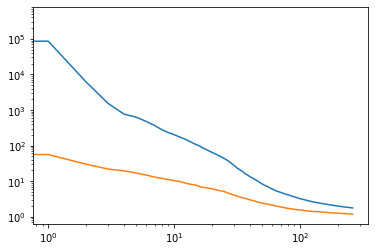

In [34]:
plt.loglog(all_losses)
plt.loglog(all_tests)

In [35]:
train_dataset._getitemtime

0.041985273361206055

In [36]:
train_dataset._collatetime

10.089063167572021

TEST MAE: 0.032659706016333896 eV/at


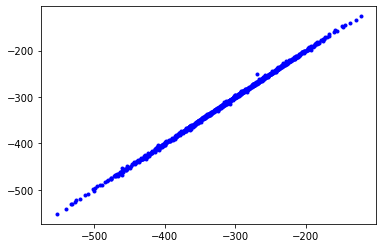

In [37]:
plt.plot(predicted.numpy(), reference.numpy(), 'b.')
print(f"TEST MAE: {test_mae.item()/len(frames[0])} eV/at")

In [38]:
with torch.no_grad():
    tpredicted = []
    treference = []
    for tcomposition, tradial_spectrum, tspherical_expansions, tenergies, _ in train_dataloader:
        treference.append(tenergies)
        predicted_e, _ = model(tcomposition, tradial_spectrum, tspherical_expansions, forward_forces=False)
        tpredicted.append(predicted_e)

    treference = torch.vstack(treference)
    tpredicted = torch.vstack(tpredicted)
    tmae = loss_mae(tpredicted, treference)/n_train

TRAIN MAE: 0.024634098247149933 eV/at


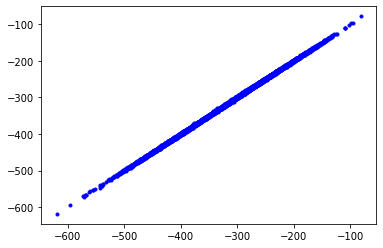

In [39]:
plt.plot(tpredicted, treference, 'b.')
print(f"TRAIN MAE: {tmae.item()/len(frames[0])} eV/at")

# Predicting forces with forward propagation

In [ ]:
def evaluate_model_with_forces(model, dataloader):
    predicted_e = []
    reference_e = []
    predicted_f = []
    reference_f = []
    for frame, radial_spectrum, spherical_expansions, energies, forces in dataloader:
        reference_e.append(energies)
        reference_f.append(forces)
        e, f = model(frame, radial_spectrum, spherical_expansions, forward_forces=True)
        predicted_e.append(e)
        predicted_f.append(f)

    reference_e = torch.vstack(reference_e)
    predicted_e = torch.vstack(predicted_e)

    reference_f = torch.vstack(reference_f)
    predicted_f = torch.vstack(predicted_f)

    return reference_e, predicted_e, reference_f, predicted_f

In [ ]:
def parity_plots(reference_e, predicted_e, reference_f, predicted_f):
    predicted_e = predicted_e.detach()
    predicted_f = predicted_f.detach()

    fig, (ax_e, ax_f) = plt.subplots(1, 2, figsize=(16, 8))

    mae = loss_mae(predicted_e, reference_e)
    rmse = loss_rmse(predicted_e, reference_e)
    ax_e.scatter(reference_e.cpu(), predicted_e.cpu())
    x = (torch.min(reference_e.flatten()).item(), torch.max(reference_e.flatten()).item())
    ax_e.plot(x, x, color="red")
    ax_e.set_title(f"energies, MAE={mae:.4}, RMSE={rmse:.4}")
    ax_e.set_xlabel("actual")
    ax_e.set_ylabel("predicted")

    mae = loss_mae(predicted_f, reference_f)
    rmse = loss_rmse(predicted_f, reference_f)
    ax_f.scatter(reference_f.cpu(), predicted_f.cpu())
    x = (torch.min(reference_f.flatten()).item(), torch.max(reference_f.flatten()).item())
    ax_f.plot(x, x, color="red")
    ax_f.set_title(f"forces, MAE={mae:.4}, RMSE={rmse:.4}")
    ax_f.set_xlabel("actual")
    ax_f.set_ylabel("predicted")

    return fig

In [ ]:
fig = parity_plots(*evaluate_model_with_forces(model, test_dataloader_grad))

In [ ]:
def check_finite_differences(model, frame, delta=1e-6):
    frame = frame.copy()
    delta_frame = frame.copy()
    delta_frame.positions[3, 1] += delta

    dataset = AtomisticDataset(
        [frame, delta_frame], 
        all_species, 
        HYPERS_GRAD, 
        torch.zeros(2, 1), 
        radial_spectrum_n_max=12,
    )
    dataloader = create_dataloader(
        dataset,
        batch_size=len(dataset),
        shuffle=False,
        device=device,
    )

    for frame, radial_spectrum, spherical_expansions, _, _ in dataloader:
        predicted_e, predicted_f = model(frame, radial_spectrum, spherical_expansions, forward_forces=True)

    finite_diff = - (predicted_e[1] - predicted_e[0]) / delta
    print("finite difference =", finite_diff.item())
    print("computed gradient =", predicted_f[3, 1].item())

In [ ]:
if torch.get_default_dtype() == torch.float64:
    delta = 1e-6
else:
    delta = 1e-3

check_finite_differences(model, train_frames[22], delta)